In [16]:
library(Matrix)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(viridis))
library(RColorBrewer)
library(ComplexHeatmap)
library(data.table)
library(ggrepel)

In [17]:
prop_area = function(obj_parse) {
    samples = sort(unique(obj_parse$timepoint))
    dflist = list()
    for (i in 1:length(unique(obj_parse$timepoint))){
      tp=obj_parse@meta.data[obj_parse@meta.data$timepoint == samples[i],]
      tp_df=as.data.frame(table(tp$subtypes))
      tp_df$percentage=tp_df$Freq/nrow(tp)
      tp_df$timepoint=rep(i,nrow(tp_df))
      dflist[[i]]=tp_df
    }
    df = do.call(rbind, dflist)
    df <- df[order(df$timepoint),]
    colnames(df)= c("subtypes","Freq","percentage","timepoint")
    return(df)
}


In [18]:
tissue_palette = c('Adrenal' = '#ff9458',
                   'Cortex' =  '#ffe578',
                   'Hippocampus' = '#967add',
                   'Gastrocnemius' = '#34b0d8',
                   'Heart' = '#ff9aaf')

tp_palette = c('PND_04' = '#e1c1da',
                'PND_10' = '#f0a1e0',
                'PND_14' = '#ff83f1',
                'PND_25' = '#d453d7',
                'PND_36' = '#ae01d7',
                'PNM_02' = '#970083',
                'PNM_18' = '#560085')

rep_palette <- c(
  '0' = '#ffffe3',
  '1' = '#d9efa4',
  '2' = '#99d386',
  '3' = '#51a35d',
  '4' = '#196e3a'
)

tissues = c("Adrenal","Cortex","Hippocampus","Heart","Gastrocnemius")

# Fig. 1B

In [19]:
summary = read.csv("data/enc4_mouse_experiment_summary.csv")
summary$Age = summary$Timepoint
summary$Timepoint = NULL
summary$tissue_timepoint = paste(summary$Tissue, summary$Age)

In [20]:
meta = unique(summary[,c("tissue_timepoint","Tissue","Age")])


In [21]:
summary_collapsed = summary %>%
  group_by(Assay, tissue_timepoint) %>%
  summarize(total_replicates = sum(N_biosample_reps))
summary_matrix = spread(summary_collapsed, key = tissue_timepoint, value = total_replicates, fill = 0)
rn = summary_matrix$Assay
summary_matrix$Assay = NULL
summary_matrix = as.matrix(summary_matrix)
rownames(summary_matrix) = rn

summary_matrix = summary_matrix[,match(meta$tissue_timepoint,colnames(summary_matrix))]
summary_matrix = summary_matrix[c("Short read RNA-seq","MicroRNA-seq","Long read RNA-seq","Short read snRNA-seq","Long read snRNA-seq","10x Multiome"),]                                 
                                       

`summarise()` has grouped output by 'Assay'. You can override using the
`.groups` argument.


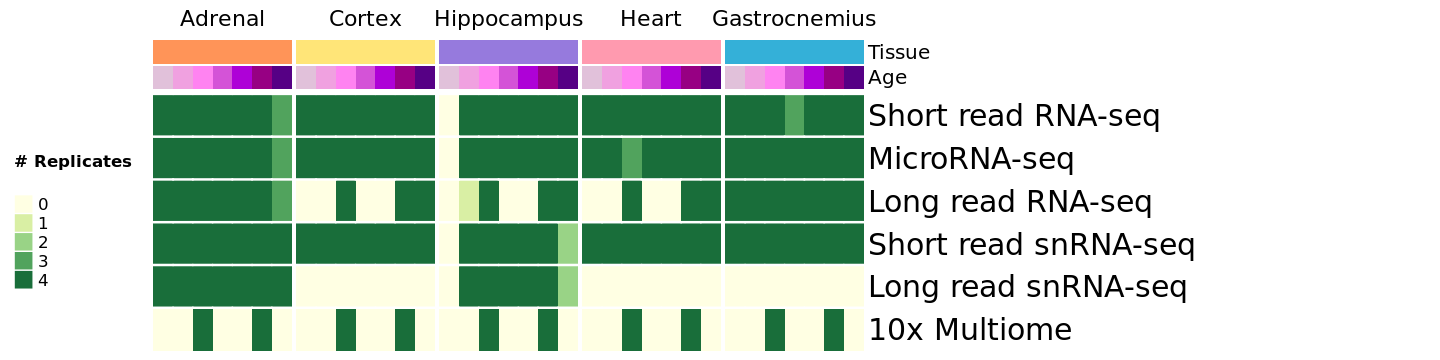

In [22]:
column_ha = HeatmapAnnotation(Tissue = setNames(meta$Tissue, meta$Tissue),
                              Age = setNames(meta$Age, meta$Age),
                              col = list(Tissue = tissue_palette, 
                                         Age = tp_palette),
                             show_legend = FALSE)

white.line = function(j, i, x, y, w, h, fill) { grid.lines(x = c(x - w/2, x + w / 2), 
                                                            y = c(y + h / 2, y + h / 2), 
                                                            gp = gpar(col = 'white', lwd = 2))}
                                                

options(repr.plot.width = 12, repr.plot.height = 3)

draw(Heatmap(summary_matrix,
                  column_split = factor(meta$Tissue, levels = tissues),
                  cell_fun = white.line,
                  col = rep_palette,
                  top_annotation = column_ha,
                  name = paste0("# Replicates       \n"), 
                  row_names_gp = gpar(fontsize = 18),
                  cluster_rows = FALSE,
                  cluster_columns = FALSE,
                  show_column_names = FALSE,
                  show_row_names = TRUE),
     heatmap_legend_side = "left",
     padding = unit(c(2, 3, 2, 60), "mm"))


In [27]:
pdf(file="fig1/fig1b_assay_summary.pdf", width = 12, height = 3)

draw(Heatmap(summary_matrix,
                  column_split = factor(meta$Tissue, levels = tissues),
                  cell_fun = white.line,
                  col = rep_palette,
                  top_annotation = column_ha,
                  name = paste0("# Replicates       \n"), 
                  row_names_gp = gpar(fontsize = 18),
                  cluster_rows = FALSE,
                  cluster_columns = FALSE,
                  show_column_names = FALSE,
                  show_row_names = TRUE),
     heatmap_legend_side = "left",
     padding = unit(c(2, 3, 2, 60), "mm"))

dev.off()

png 
  2

In [ ]:
png(file="fig1/fig1b_assay_summary.png", width = 12, height = 3,units="in",res=1200)

draw(Heatmap(summary_matrix,
                  column_split = factor(meta$Tissue, levels = tissues),
                  cell_fun = white.line,
                  col = rep_palette,
                  top_annotation = column_ha,
                  name = paste0("# Replicates       \n"), 
                  row_names_gp = gpar(fontsize = 18),
                  cluster_rows = FALSE,
                  cluster_columns = FALSE,
                  show_column_names = FALSE,
                  show_row_names = TRUE),
     heatmap_legend_side = "left",
     padding = unit(c(2, 3, 2, 60), "mm"))

dev.off()

png 
  2

# Fig. 1C

In [29]:
ncells_celltype = function(obj){
    median_umis = list()
    median_genes = list()
    for (i in 1:length(unique(obj$celltypes))){
        ct = unique(obj$celltypes)[i]
        obj_subset = subset(obj, subset = celltypes == ct)
        median_umis[[i]] = median(obj_subset$nCount_RNA)
        median_genes[[i]] = median(obj_subset$nFeature_RNA)

    }
    df = as.data.frame(unlist(median_umis))
    colnames(df) = "median_umis"
    df$median_genes = unlist(median_genes)
    df$celltype = unique(obj$celltypes)

    df2 = as.data.frame(table(obj$celltypes))
    colnames(df2) = c("celltype","ncells")

    out = left_join(df, df2)
    return(out)
}


In [30]:
df_list = list()

for (tissue in tissues){
    tissue = tolower(tissue)
    print(tissue)
    obj = readRDS(paste0("../snrna/",tissue,"/seurat/",tissue,"_Parse_10x_integrated.rds"))
    df_list[[tissue]] = ncells_celltype(obj)
    df_list[[tissue]]$tissue = tissue
    
    if (tissue == "cortex"){
        df_list[[tissue]]$cortex = "cortex"
    } else {
        df_list[[tissue]]$cortex = "not_cortex"
    }
 
    
}

[1] "adrenal"


Joining, by = "celltype"


[1] "cortex"


Joining, by = "celltype"


[1] "hippocampus"


Joining, by = "celltype"


[1] "heart"


Joining, by = "celltype"


[1] "gastrocnemius"


Joining, by = "celltype"


In [31]:
df = do.call(rbind, df_list)

In [32]:
cols = read.csv("data/enc4_mouse_snrna_celltypes.csv")
cols = unique(cols[cols$celltypes %in% df$celltype, c("celltypes","celltype_color")])
cols = cols[match(df$celltype, cols$celltypes),]
named_cols = cols$celltype_color
names(named_cols) = cols$celltypes

Warning message:
"ggrepel: 46 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


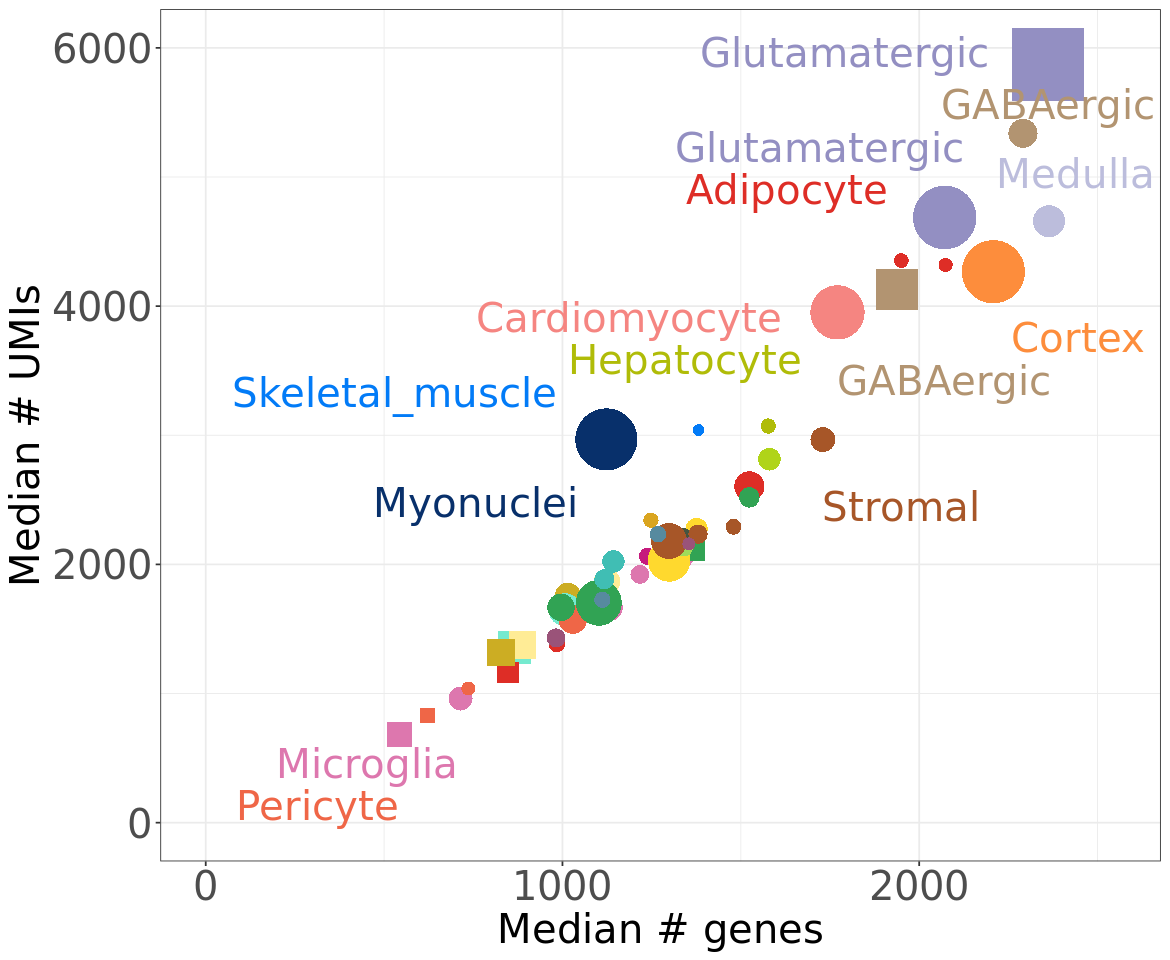

In [33]:
options(repr.plot.width = 9.75, repr.plot.height = 8)

p=ggplot(df, aes(x=median_genes, y=median_umis, color = celltype, shape = cortex, label = celltype)) + theme_bw() + 
    geom_point(aes(size=ncells)) + 
    theme(text = element_text(size = 24), 
          axis.text.x = element_text(size = 24), 
          axis.text.y = element_text(size = 24)) + 
    scale_color_manual(values = named_cols) +  
    scale_size(
    breaks = c(200, 1000, 5000, 25000, 50000, 125000),
    range = c(3, 20)) + 
    xlim(0,2550) + 
    ylim(0,6000)+ geom_text_repel(size = 8.5, point.padding = 50) + 
theme(legend.direction ="vertical",legend.position = "bottom")+
guides(color=guide_legend(ncol=3)) + 
xlab("Median # genes") + ylab("Median # UMIs") + 
scale_shape_manual(values = c(15, 16, 17, 18, 1))& NoLegend()
p

In [34]:
pdf(file="fig1/fig1c_median_genes_scatter.pdf", width = 9.75, height = 8)

p

dev.off()

Warning message:
"ggrepel: 37 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


png 
  2

In [36]:
png(file="fig1/fig1c_median_genes_scatter.png", width = 9.75, height = 8, units="in",res=1200)

p

dev.off()

Warning message:
"ggrepel: 38 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


png 
  2

# Fig. 1D

## Adrenal

In [37]:
tissue = "adrenal"
obj_parse = readRDS(paste0("../snrna/",tissue,"/seurat/",tissue,"_Parse.rds"))

df = prop_area(obj_parse)

df$subtypes = factor(df$subtypes, levels = c("Adipocyte_cycling","Adipocyte","Capsule","Endothelial_cycling","Endothelial",
                                             "Fibroblast","Hepatocyte","Macrophage","Smooth_muscle",
                                            "Skeletal_muscle","Stromal","Sox10","Medulla_early","Medulla_EPI",
                                            "Medulla_NE","Cortex_cycling","Cortex_ZG","Cortex_ZF","Male_only_ZF","X_zone"))


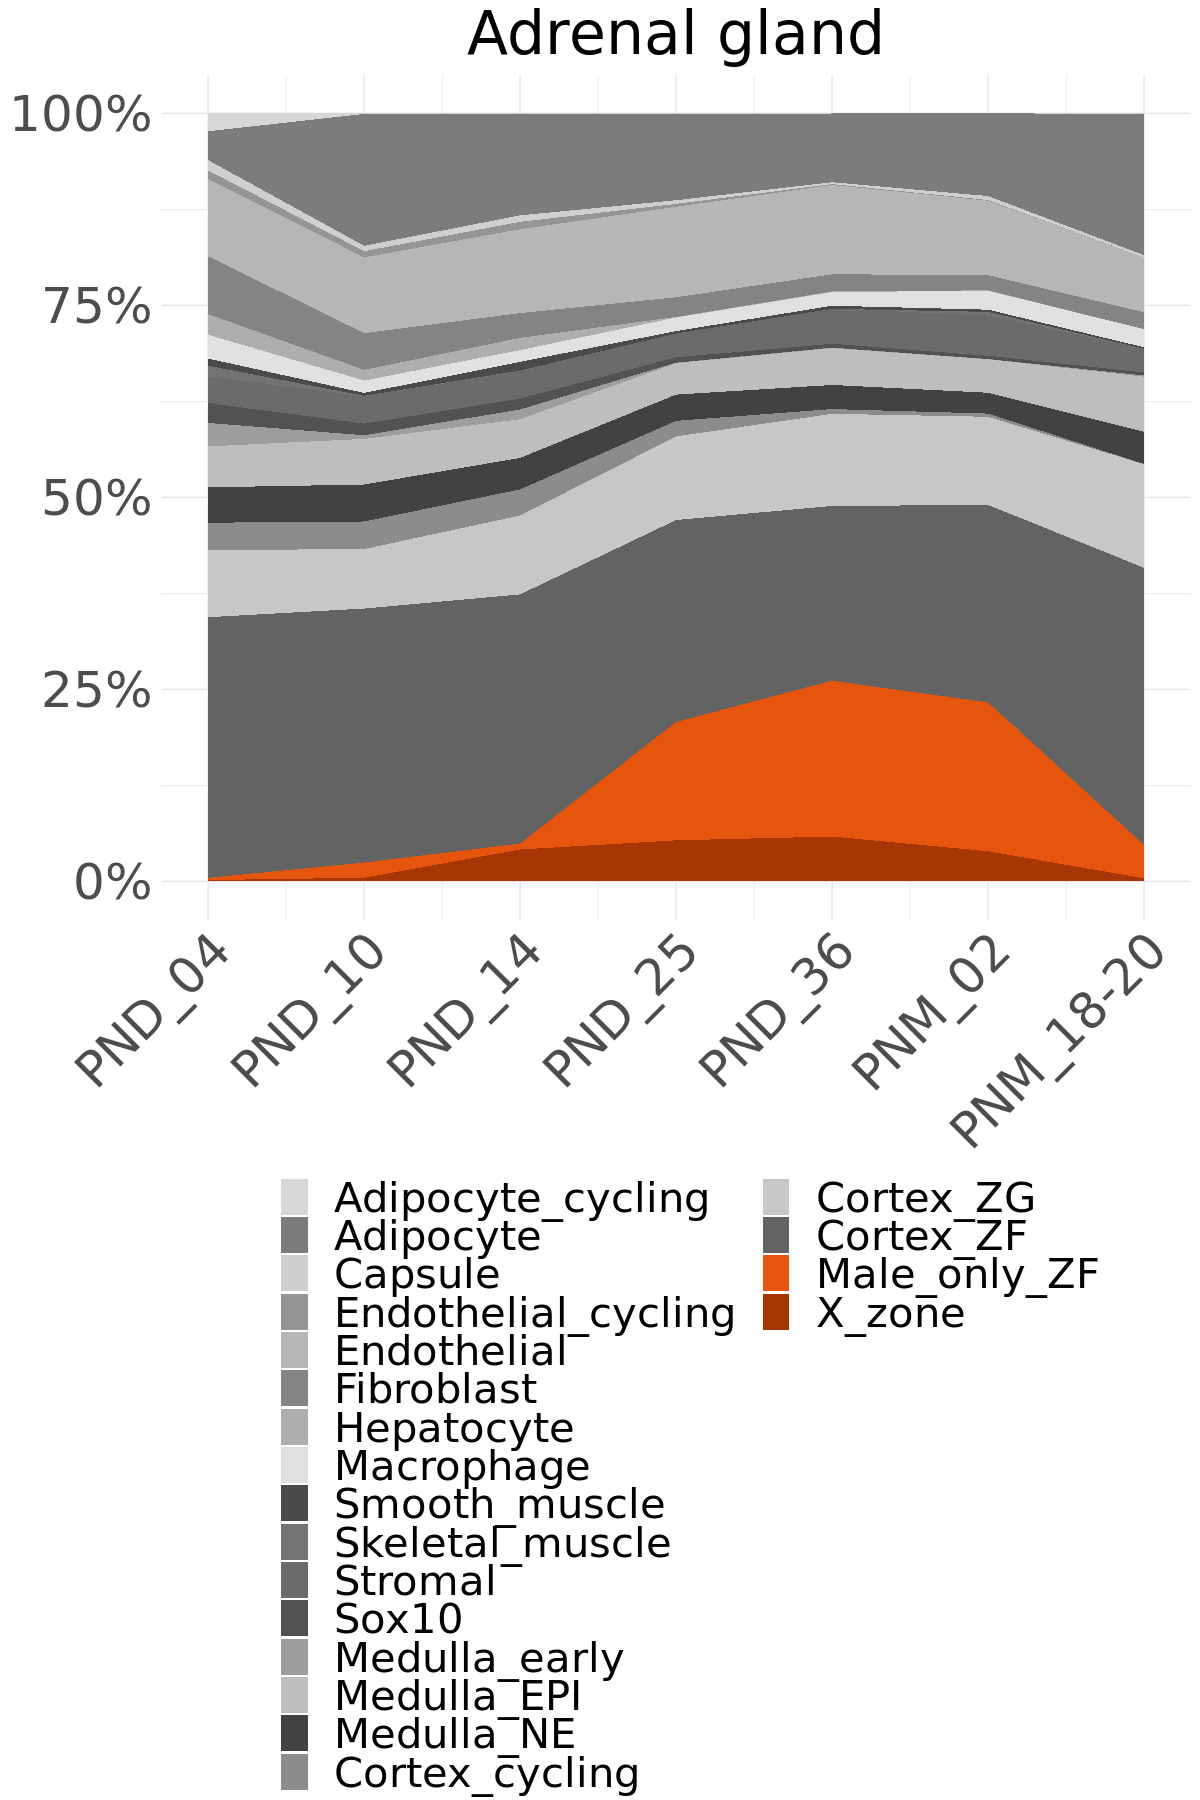

In [38]:
cols = read.csv(paste0("../snrna/ref/",tissue,"_celltypes_colors.csv"))
cols = unique(cols[,c("subtypes","fig1_color")])
col_palette = cols$fig1_color
names(col_palette) = cols$subtypes

grey_palette = sample(colorRampPalette(c("gray88", "gray26"))(length(col_palette)))
col_palette[is.na(col_palette)] = grey_palette[is.na(col_palette)]

options(repr.plot.width = 10, repr.plot.height = 15)

a = ggplot(df, aes(x=timepoint, y=percentage, fill=subtypes)) + 
    scale_fill_manual(values = col_palette) + 
    labs(title = "Adrenal gland")+
    geom_area()  +
    scale_x_continuous(breaks = c(1,2,3,4,5,6,7),labels= c("PND_04","PND_10","PND_14",
                                                         "PND_25","PND_36","PNM_02","PNM_18-20")) +
    scale_y_continuous(labels = scales::percent,
                     limits = c(0, 1)) +
    theme_minimal()+theme(text = element_text(size = 30), plot.title = element_text(hjust = 0.5)) +
    theme(axis.text.y = element_text(size = 30), axis.text.x = element_text(size = 30, angle = 45, hjust = 1)) + 
    theme(axis.title.x = element_blank(), axis.title.y = element_blank()) +
    theme(legend.position="bottom", 
          legend.box="vertical", 
          legend.margin=margin(),
          legend.title=element_blank(),
          legend.text=element_text(size=25))+
    theme(plot.title=element_text(hjust=0.5),plot.subtitle=element_text(hjust=0.5)) + 
    guides(fill=guide_legend(nrow=16))

a

In [39]:
pdf(file="fig1/fig1d_adrenal_proportion_dynamics.pdf", width = 10, height = 15)

a

dev.off()

png 
  2

In [40]:
png(file="fig1/fig1d_adrenal_proportion_dynamics.png", width = 10, height = 15, units="in",res=1200)

a

dev.off()

png 
  2

# Cortex

In [41]:
tissue = "cortex"
obj_parse = readRDS(paste0("../snrna/",tissue,"/seurat/",tissue,"_Parse.rds"))

df = prop_area(obj_parse)

df$subtypes = factor(df$subtypes, levels = c("Endothelial","Pericyte","VLMC",
          "Microglia", "Astrocyte",                               
          "GABA_early","Meis2","Lamp5","Vip","Sst","Pvalb",
          "Glut_early","Car3","L2/3_IT","L2/3_IT_PPP","L3_IT_ENT","L4_IT","L5_IT","L5_PT","L6_IT","L6/6b_CT","NP_SUB",
          "OPC","COP","MFOL","MOL"))


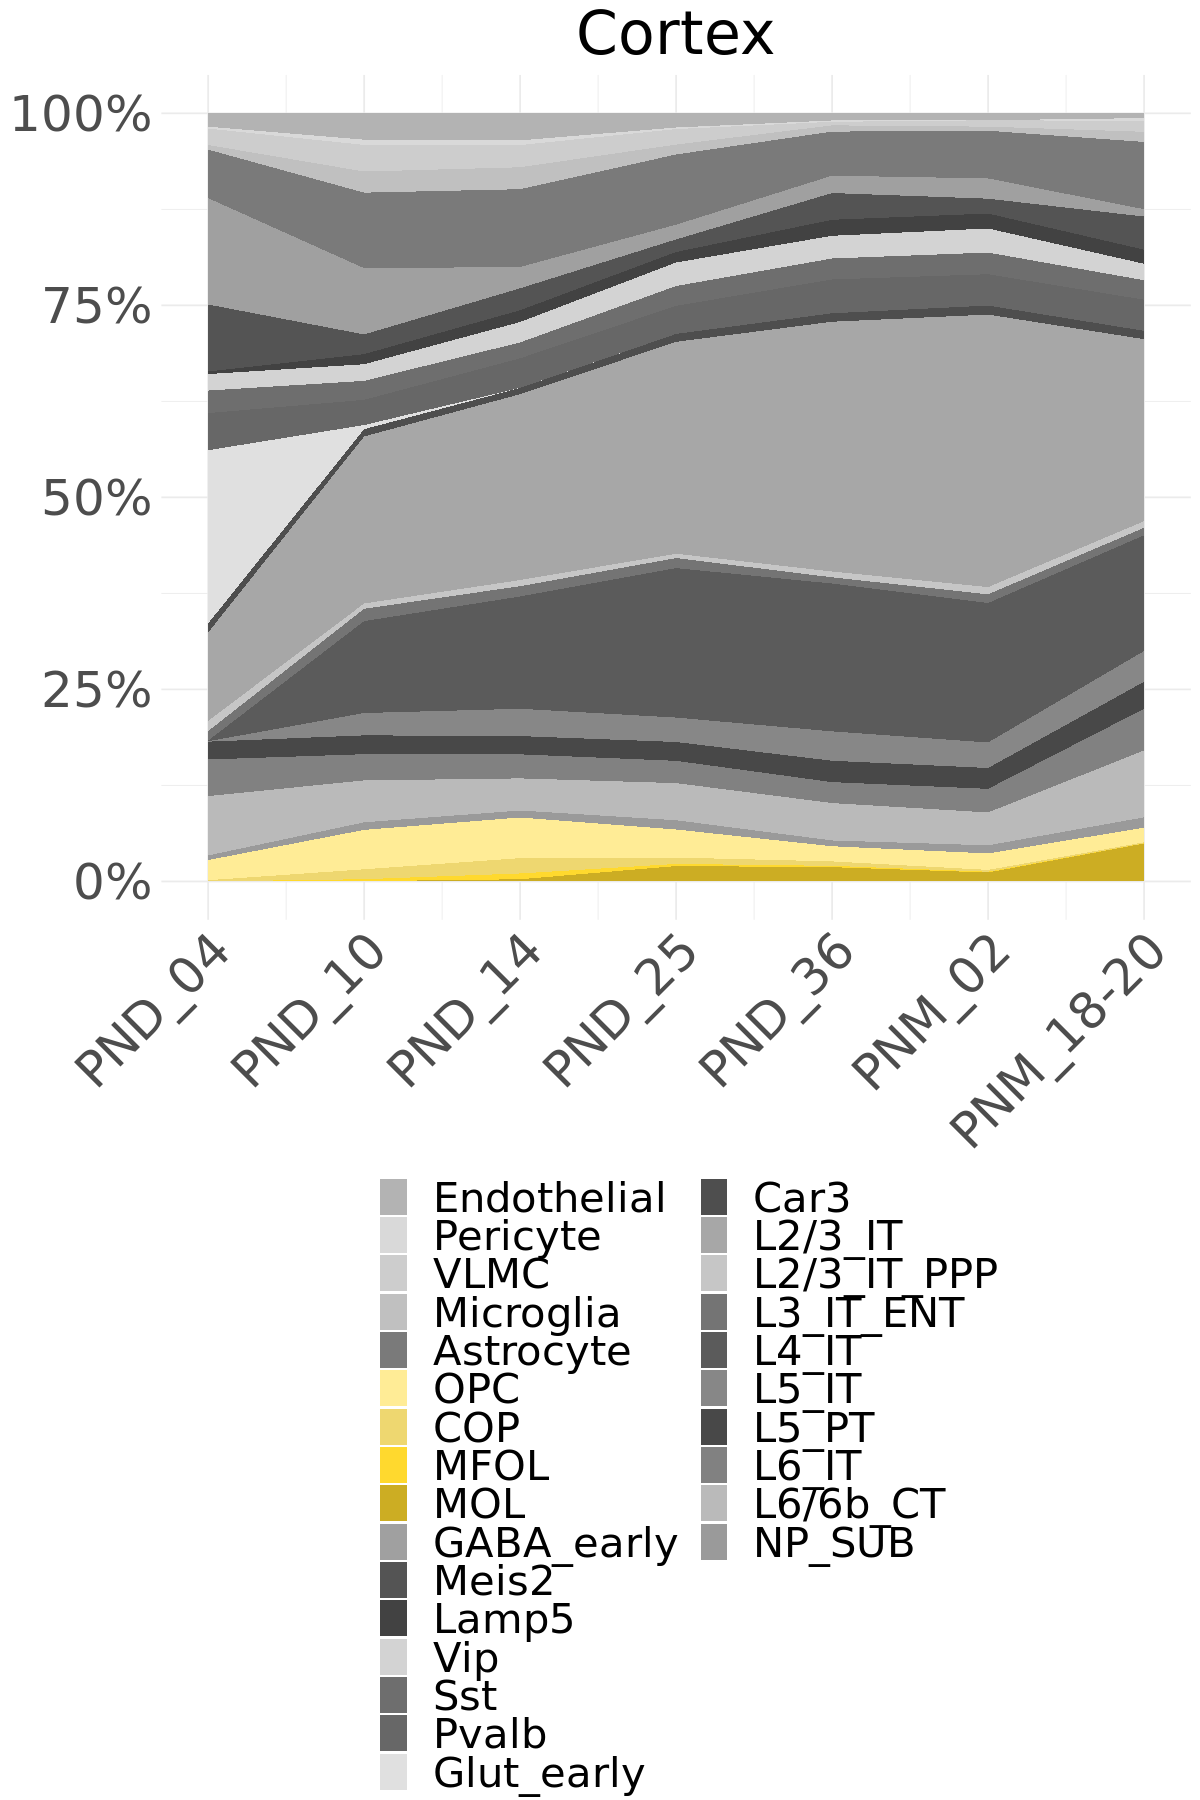

In [42]:
cols = read.csv(paste0("../snrna/ref/",tissue,"_celltypes_colors.csv"))
cols = unique(cols[,c("subtypes","fig1_color")])
col_palette = cols$fig1_color
names(col_palette) = cols$subtypes

grey_palette = sample(colorRampPalette(c("gray88", "gray26"))(length(col_palette)))
col_palette[is.na(col_palette)] = grey_palette[is.na(col_palette)]

options(repr.plot.width = 10, repr.plot.height = 15)

c = ggplot(df, aes(x=timepoint, y=percentage, fill=subtypes)) + 
    scale_fill_manual(values = col_palette) + 
    labs(title = "Cortex")+
    geom_area()  +
    scale_x_continuous(breaks = c(1,2,3,4,5,6,7),labels= c("PND_04","PND_10","PND_14",
                                                         "PND_25","PND_36","PNM_02","PNM_18-20")) +
    scale_y_continuous(labels = scales::percent,
                     limits = c(0, 1)) +
    theme_minimal()+theme(text = element_text(size = 30), plot.title = element_text(hjust = 0.5)) +
    theme(axis.text.y = element_text(size = 30), axis.text.x = element_text(size = 30, angle = 45, hjust = 1)) + 
    theme(axis.title.x = element_blank(), axis.title.y = element_blank()) +
    theme(legend.position="bottom", 
          legend.box="vertical", 
          legend.margin=margin(),
          legend.title=element_blank(),
          legend.text=element_text(size=25))+
    theme(plot.title=element_text(hjust=0.5),plot.subtitle=element_text(hjust=0.5)) + 
    guides(fill=guide_legend(nrow=16))

c

In [43]:
pdf(file="fig1/fig1d_cortex_proportion_dynamics.pdf", width = 10, height = 15)

c

dev.off()

png 
  2

In [44]:
png(file="fig1/fig1d_cortex_proportion_dynamics.png", width = 10, height = 15, units="in",res=1200)

c

dev.off()

png 
  2

## Hippocampus

In [45]:
tissue = "hippocampus"
obj_parse = readRDS(paste0("../snrna/",tissue,"/seurat/",tissue,"_Parse.rds"))

df = prop_area(obj_parse)

df$subtypes = factor(df$subtypes, levels = c("Endothelial","Pericyte",
                                             "VLMC","Ependymal","Microglia","Astrocyte",
                                             "Meis2","Lamp5","Vip","Sst","Pvalb",
                                             "CR","L2/3","L5/6","SUB_ProS","Glut_other","CA1","CA3",
                                            "DG_early","DG",
                                            "OPC","MFOL", "MOL"))


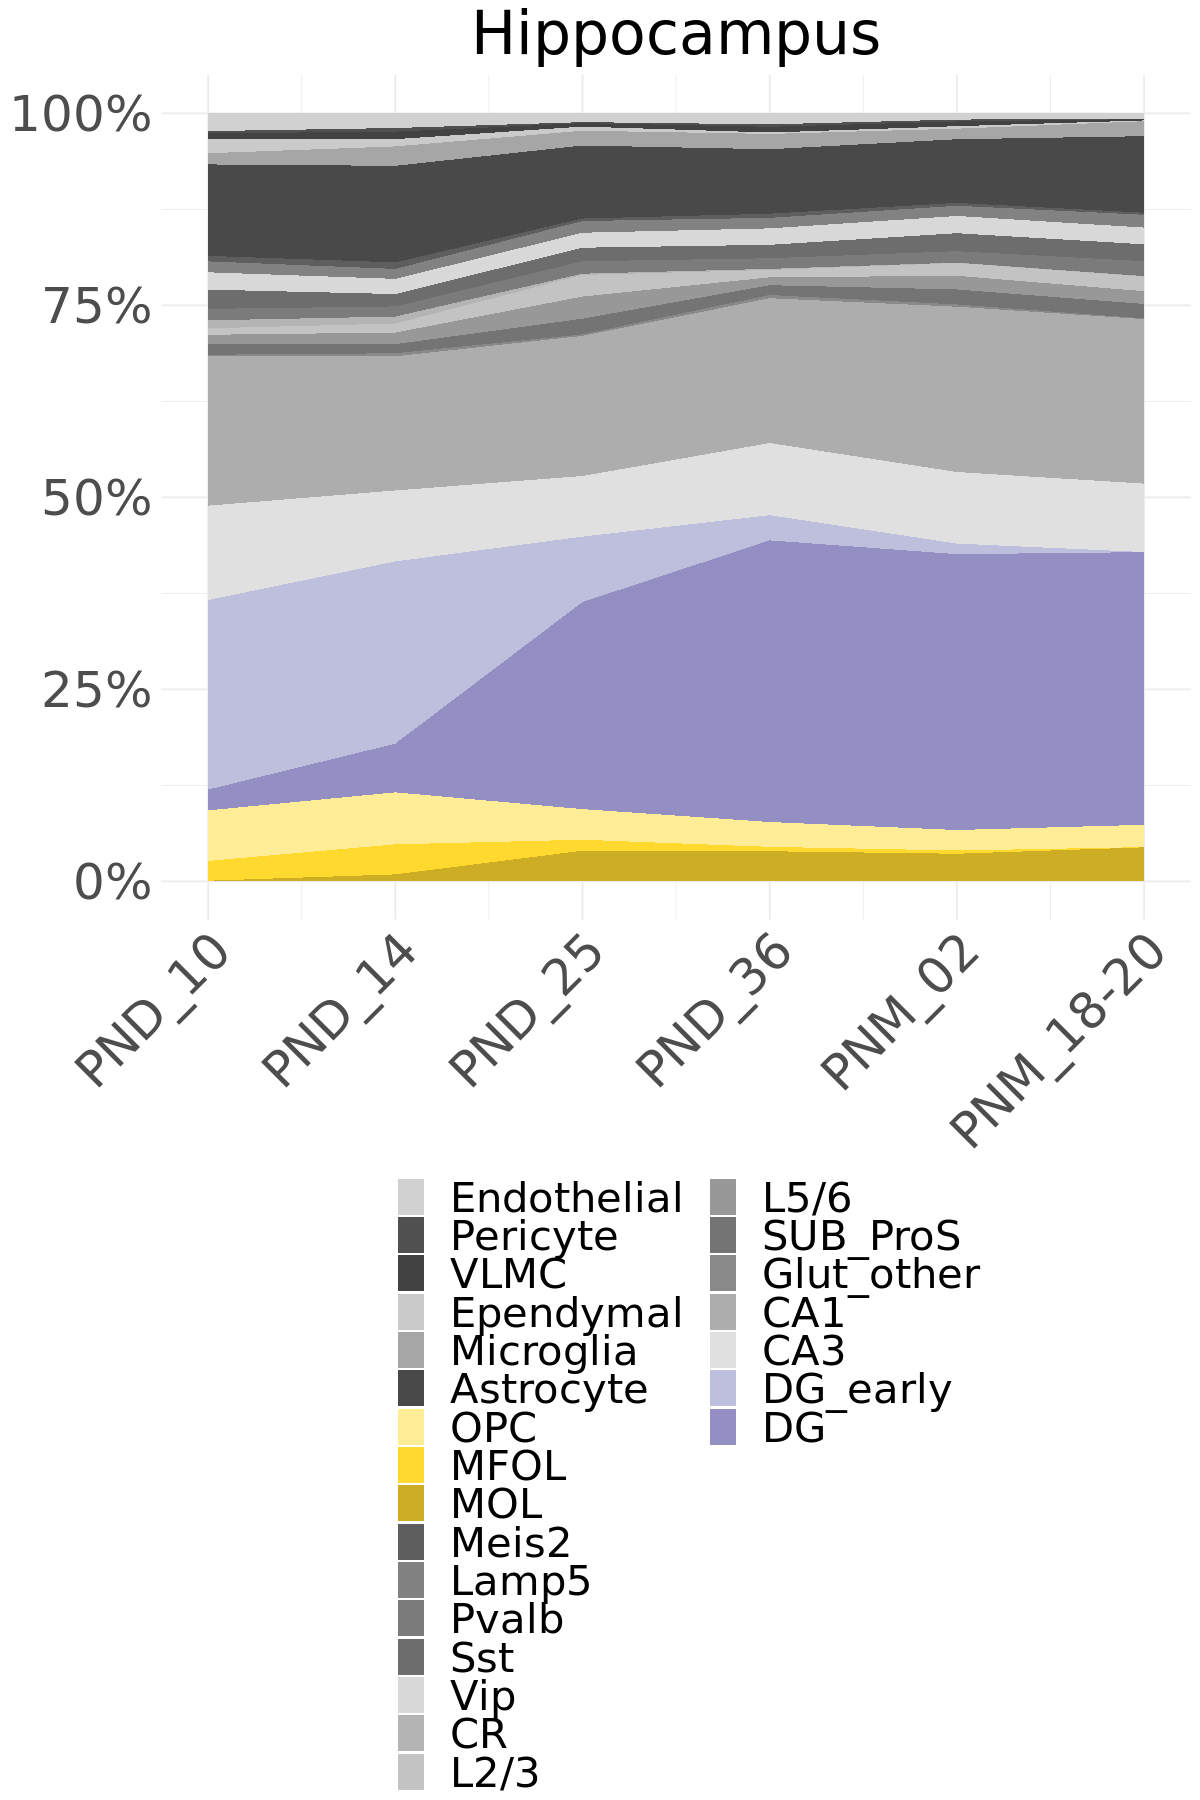

In [46]:
cols = read.csv(paste0("../snrna/ref/",tissue,"_celltypes_colors.csv"))
cols = unique(cols[,c("subtypes","fig1_color")])
col_palette = cols$fig1_color
names(col_palette) = cols$subtypes

grey_palette = sample(colorRampPalette(c("gray88", "gray26"))(length(col_palette)))
col_palette[is.na(col_palette)] = grey_palette[is.na(col_palette)]

options(repr.plot.width = 10, repr.plot.height = 15)

h = ggplot(df, aes(x=timepoint, y=percentage, fill=subtypes)) + 
    scale_fill_manual(values = col_palette) + 
    labs(title = "Hippocampus")+
    geom_area()  +
    scale_x_continuous(breaks = c(1,2,3,4,5,6),labels= c("PND_10","PND_14",
                                                         "PND_25","PND_36","PNM_02","PNM_18-20")) +
    scale_y_continuous(labels = scales::percent,
                     limits = c(0, 1)) +
    theme_minimal()+theme(text = element_text(size = 30), plot.title = element_text(hjust = 0.5)) +
    theme(axis.text.y = element_text(size = 30), axis.text.x = element_text(size = 30, angle = 45, hjust = 1)) + 
    theme(axis.title.x = element_blank(), axis.title.y = element_blank()) +
    theme(legend.position="bottom", 
          legend.box="vertical", 
          legend.margin=margin(),
          legend.title=element_blank(),
          legend.text=element_text(size=25))+
    theme(plot.title=element_text(hjust=0.5),plot.subtitle=element_text(hjust=0.5)) + 
    guides(fill=guide_legend(nrow=16))

h

In [47]:
pdf(file="fig1/fig1d_hipp_proportion_dynamics.pdf", width = 10, height = 15)

h

dev.off()

png 
  2

In [48]:
png(file="fig1/fig1d_hipp_proportion_dynamics.png", width = 10, height = 15, units="in",res=1200)

h

dev.off()

png 
  2

## Heart

In [49]:
tissue = "heart"
obj_parse = readRDS(paste0("../snrna/",tissue,"/seurat/",tissue,"_Parse.rds"))

df = prop_area(obj_parse)

df$subtypes = factor(df$subtypes, levels = c("Adipocyte","Endothelial_cycling",
                                             "Endothelial_juvenile",
                                             "Endothelial_adult",
                                             "Lymphatic_endothelial",
                                             "Endocardial",
                                             "Fibroblast_cycling","Fibroblast_juvenile","Fibroblast_adult",
                                             "Macrophage_cycling","Macrophage","Lymphocyte",
                                             "Smooth_muscle1","Smooth_muscle2",
                                             "Pericyte_cycling","Pericyte","Schwann",
                                             "Epicardial","Cardiomyocyte_atrial","Cardiomyocyte_cycling",
                                             "Cardiomyocyte_infant","Cardiomyocyte_juvenile","Cardiomyocyte_adult"))




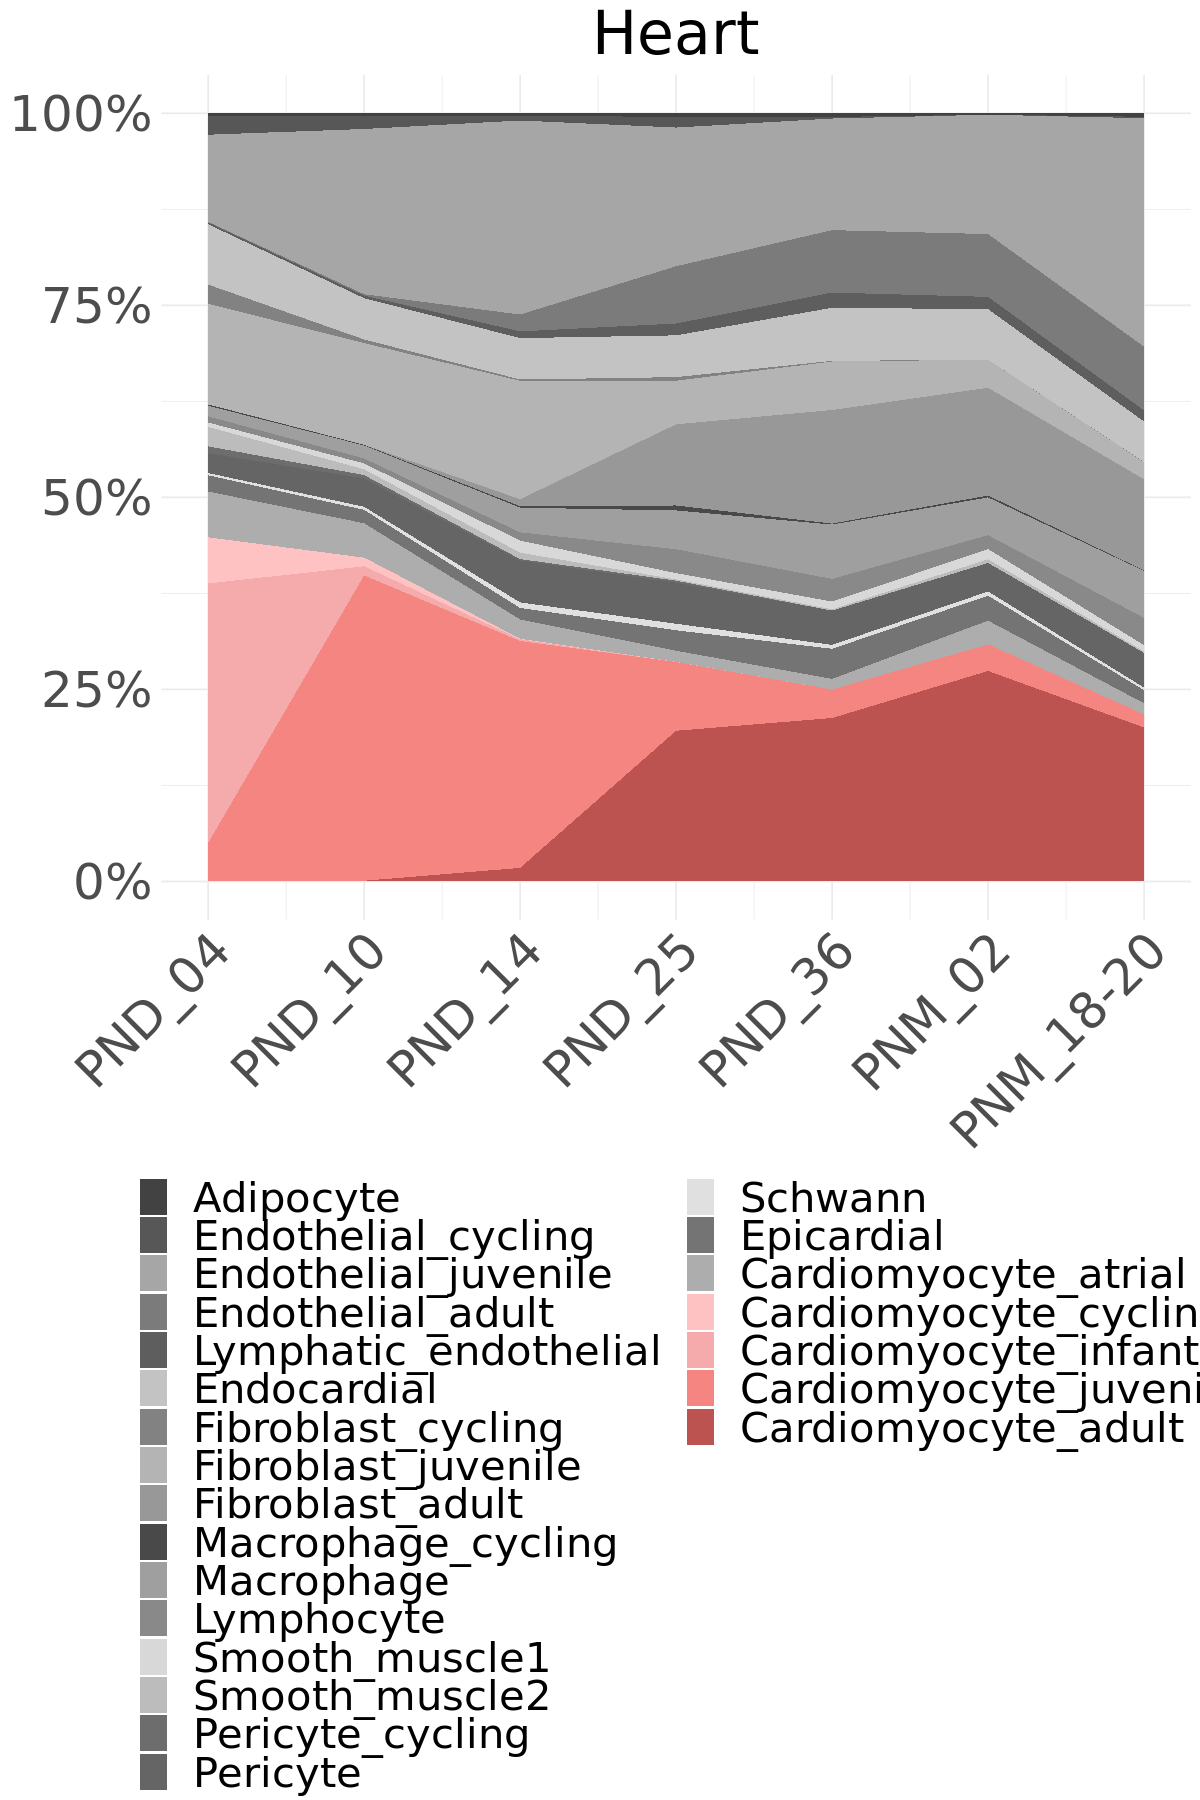

In [50]:
cols = read.csv(paste0("../snrna/ref/",tissue,"_celltypes_colors.csv"))
cols = unique(cols[,c("subtypes","fig1_color")])
col_palette = cols$fig1_color
names(col_palette) = cols$subtypes

grey_palette = sample(colorRampPalette(c("gray88", "gray26"))(length(col_palette)))
col_palette[is.na(col_palette)] = grey_palette[is.na(col_palette)]

options(repr.plot.width = 10, repr.plot.height = 15)

ht = ggplot(df, aes(x=timepoint, y=percentage, fill=subtypes)) + 
    scale_fill_manual(values = col_palette) + 
    labs(title = "Heart")+
    geom_area()  +
    scale_x_continuous(breaks = c(1,2,3,4,5,6,7),labels= c("PND_04","PND_10","PND_14",
                                                         "PND_25","PND_36","PNM_02","PNM_18-20")) +
    scale_y_continuous(labels = scales::percent,
                     limits = c(0, 1)) +
    theme_minimal()+theme(text = element_text(size = 30), plot.title = element_text(hjust = 0.5)) +
    theme(axis.text.y = element_text(size = 30), axis.text.x = element_text(size = 30, angle = 45, hjust = 1)) + 
    theme(axis.title.x = element_blank(), axis.title.y = element_blank()) +
    theme(legend.position="bottom", 
          legend.box="vertical", 
          legend.margin=margin(),
          legend.title=element_blank(),
          legend.text=element_text(size=25))+
    theme(plot.title=element_text(hjust=0.5),plot.subtitle=element_text(hjust=0.5)) + 
    guides(fill=guide_legend(nrow=16))

ht

In [51]:
pdf(file="fig1/fig1d_heart_proportion_dynamics.pdf", width = 10, height = 15)

ht

dev.off()

png 
  2

In [52]:
png(file="fig1/fig1d_heart_proportion_dynamics.png", width = 10, height = 15, units="in",res=1200)

ht

dev.off()

png 
  2

## Gastrocnemius

In [53]:
tissue = "gastrocnemius"

obj_parse = readRDS(paste0("../snrna/",tissue,"/seurat/",tissue,"_Parse.rds"))

df = prop_area(obj_parse)

df$subtypes = factor(df$subtypes, levels = c("Adipocyte","FAP","Endothelial",
                                             "Macrophage","Lymphocyte","Smooth_muscle","Schwann","Tenocyte","MTJ","NMJ",
                                             "Satellite","Perinatal","Type1_Myonuclei","Type2X_Myonuclei","Type2A_Myonuclei","Type2B_Myonuclei"))




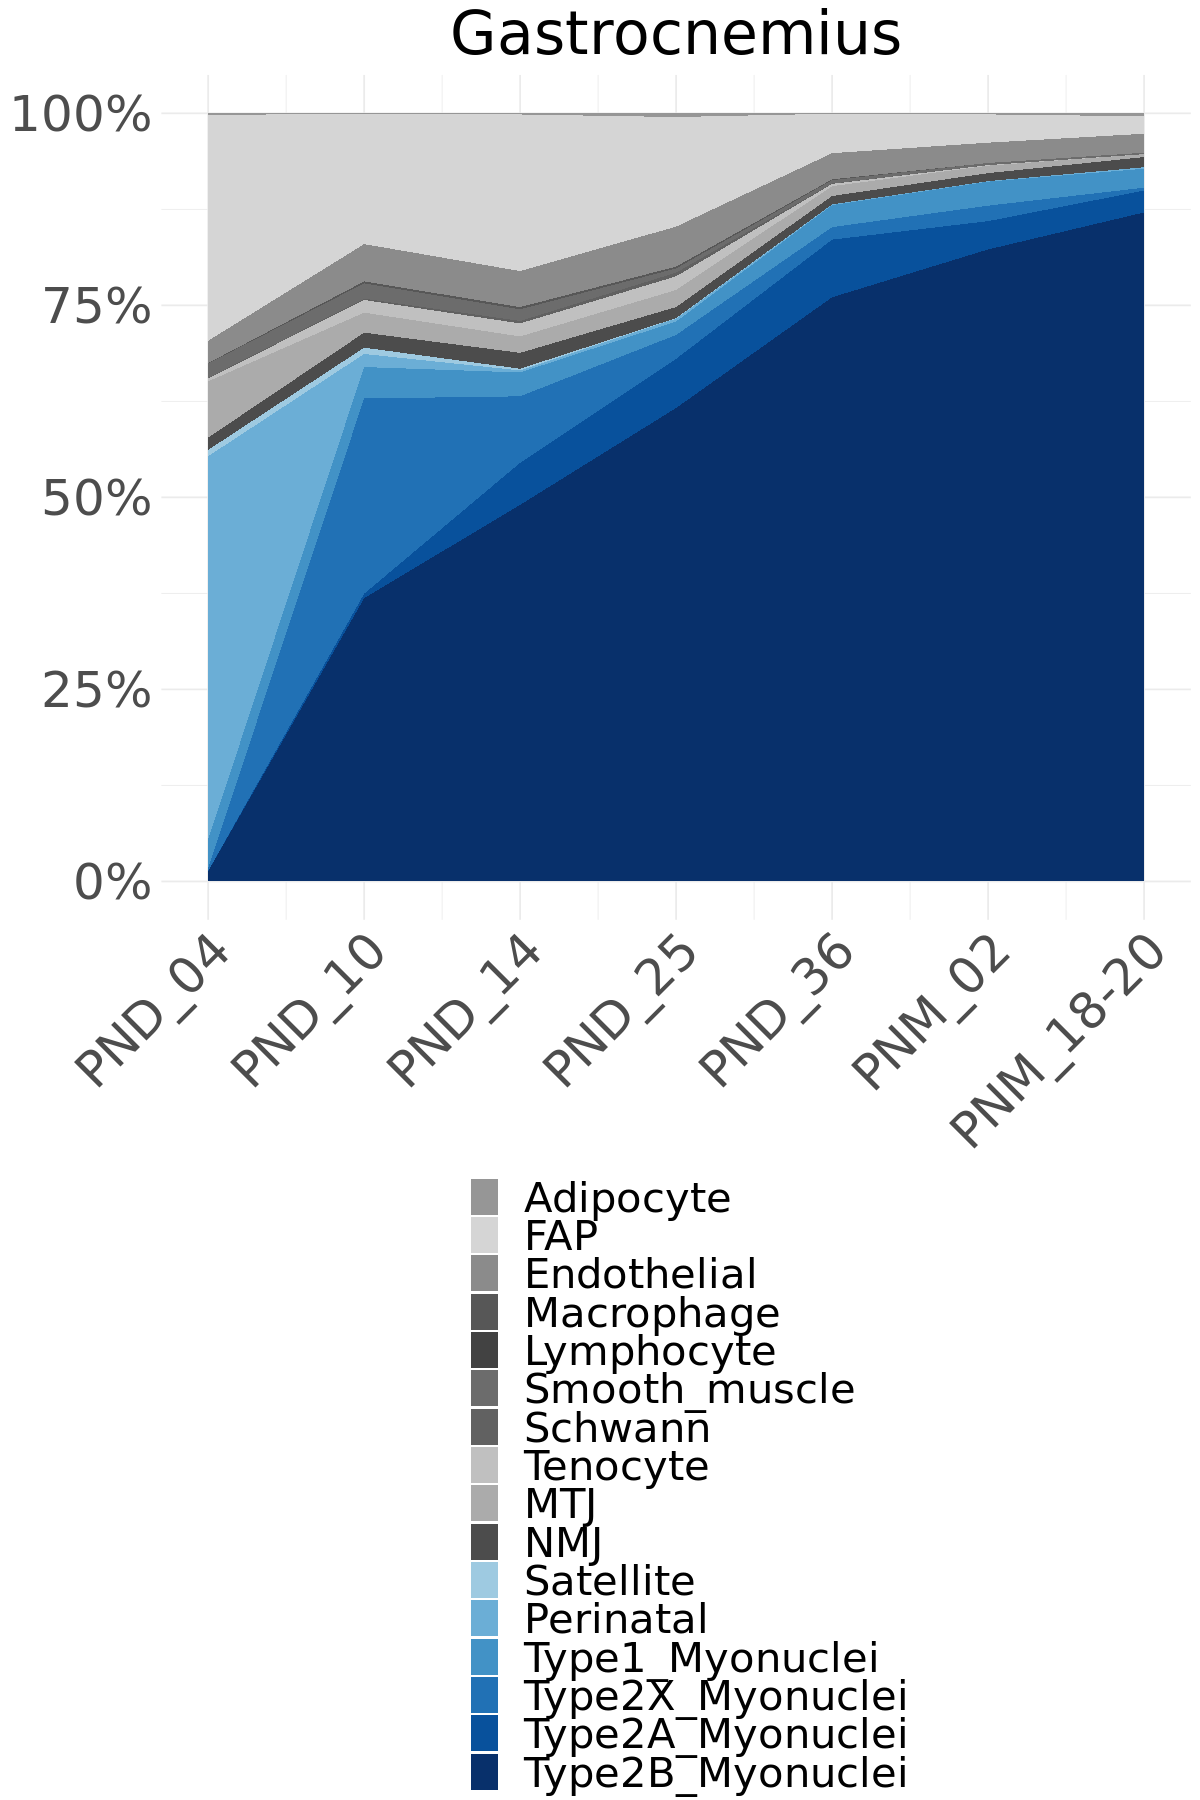

In [54]:
cols = read.csv(paste0("../snrna/ref/",tissue,"_celltypes_colors.csv"))
cols = unique(cols[,c("subtypes","fig1_color")])
col_palette = cols$fig1_color
names(col_palette) = cols$subtypes

grey_palette = sample(colorRampPalette(c("gray88", "gray26"))(length(col_palette)))
col_palette[is.na(col_palette)] = grey_palette[is.na(col_palette)]

options(repr.plot.width = 10, repr.plot.height = 15)

g= ggplot(df, aes(x=timepoint, y=percentage, fill=subtypes)) + 
    scale_fill_manual(values = col_palette) + 
    labs(title = "Gastrocnemius")+
    geom_area()  +
    scale_x_continuous(breaks = c(1,2,3,4,5,6,7),labels= c("PND_04","PND_10","PND_14",
                                                         "PND_25","PND_36","PNM_02","PNM_18-20")) +
    scale_y_continuous(labels = scales::percent,
                     limits = c(0, 1)) +
    theme_minimal()+theme(text = element_text(size = 30), plot.title = element_text(hjust = 0.5)) +
    theme(axis.text.y = element_text(size = 30), axis.text.x = element_text(size = 30, angle = 45, hjust = 1)) + 
    theme(axis.title.x = element_blank(), axis.title.y = element_blank()) +
    theme(legend.position="bottom", 
          legend.box="vertical", 
          legend.margin=margin(),
          legend.title=element_blank(),
          legend.text=element_text(size=25))+
    theme(plot.title=element_text(hjust=0.5),plot.subtitle=element_text(hjust=0.5)) + 
    guides(fill=guide_legend(nrow=16))

g

In [55]:
pdf(file="fig1/fig1d_gastroc_proportion_dynamics.pdf", width = 10, height = 15)

g

dev.off()

png 
  2

In [56]:
png(file="fig1/fig1d_gastroc_proportion_dynamics.png", width = 10, height = 15, units="in",res=1200)

g

dev.off()

png 
  2